In [1]:
MAX_SEQUENCE_LENGTH = 200 # 句子 上限200个词
EMBEDDING_DIM = 100 # 100d 词向量

### 字向量

In [2]:
good = []
bad = []
for line in open('data/goodqueries.txt'):
    good.append(line.strip('\n'))
for line in open('data/badqueries.txt'):
    bad.append(line.strip('\n'))
print('good len:', len(good))
print('bad len:', len(bad))

good len: 1294531
bad len: 48126


In [3]:
data = []
labels = []

length = len(bad)
scale = 3
data.extend(good[:length * scale]) # 只取部分数据
data.extend(bad)
labels.extend([1] * length * scale)
labels.extend([0] * length)
print('data:', len(data))
print(data[0], data[-1])

data: 192504
/103886/ <svg onload=location='//p0.al'>


In [4]:
# https://keras-cn-docs.readthedocs.io/zh_CN/latest/blog/word_embedding/
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenizer
texts = data
tokenizer = Tokenizer(char_level=True) # 字向量
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# sequences
sequences = tokenizer.texts_to_sequences(data)

# padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 175 unique tokens.
Shape of data tensor: (192504, 200)


In [5]:
import pickle

token_path = 'model/tokenizer.pkl'
pickle.dump(tokenizer, open(token_path, 'wb'))

In [6]:
import random

# 打乱顺序
index = [i for i in range(len(data))]
random.shuffle(index)
data = np.array(data)[index]
labels = np.array(labels)[index]

TRAIN_SPLIT = 0.8 # 20% 测试集
TRAIN_SIZE = int(len(data) * TRAIN_SPLIT)

X_train, X_test = data[0:TRAIN_SIZE], data[TRAIN_SIZE:]
Y_train, Y_test = labels[0:TRAIN_SIZE], labels[TRAIN_SIZE:]

In [7]:
print('train len:', len(X_train))
print('test len:', len(X_test))

train len: 154003
test len: 38501


### 训练

In [8]:
import tensorflow as tf
from keras import backend as K

G = 4 # GPU 数量
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True))
K.set_session(session)

### CNN + Bi-LSTM + CNN

In [9]:
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Flatten
from keras.layers import Dense, LSTM, Convolution1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import Bidirectional

QA_EMBED_SIZE = 64
DROPOUT_RATE = 0.3

model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Convolution1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(4))
model.add(Bidirectional(LSTM(QA_EMBED_SIZE, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE)))
model.add(Convolution1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(4))
model.add(Flatten())

model.add(Dense(QA_EMBED_SIZE))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          17600     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 128)          38528     
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 49, 128)           98816     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 47, 128)           49280     
__________

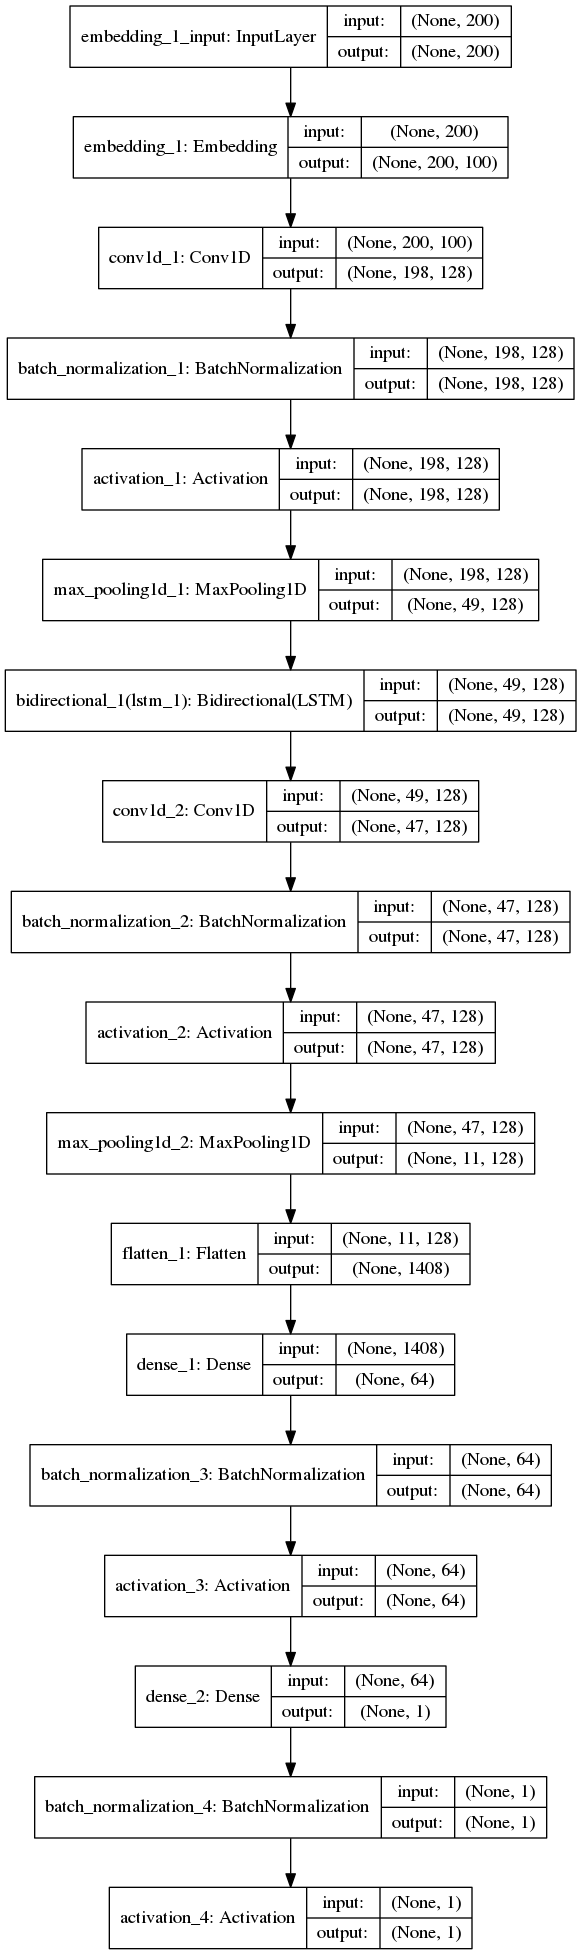

In [10]:
# 模型可视化 https://keras-cn.readthedocs.io/en/latest/other/visualization/
from keras.utils import plot_model
from IPython import display

# pip install pydot=1.2.3
# pip install pydot-ng
# sudo apt-get install graphviz
plot_model(model, to_file="img/model-cnn-blstm-cnn.png", show_shapes=True)
display.Image('img/model-cnn-blstm-cnn.png')

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import multi_gpu_model

EPOCHS = 3
BATCH_SIZE = 64 * G
VALIDATION_SPLIT = 0.3 # 30% 验证集

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_path = 'model/model-cnn-blstm-cnn.h5'
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, save_weights_only=True)
tensorboard = TensorBoard('log/tflog-cnn-blstm-cnn', write_graph=True, write_images=True)

model = multi_gpu_model(model)

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
          validation_split=VALIDATION_SPLIT, shuffle=True, 
          callbacks=[early_stopping, model_checkpoint, tensorboard])

Train on 107802 samples, validate on 46201 samples
Epoch 1/3
107802/107802 [==============================] - 148s 1ms/step - loss: 0.3313 - acc: 0.9685 - val_loss: 0.2301 - val_acc: 0.9883
Epoch 2/3
107802/107802 [==============================] - 147s 1ms/step - loss: 0.1995 - acc: 0.9934 - val_loss: 0.1497 - val_acc: 0.9955
Epoch 3/3
107802/107802 [==============================] - 139s 1ms/step - loss: 0.1375 - acc: 0.9951 - val_loss: 0.1053 - val_acc: 0.9972


In [12]:
model.evaluate(X_test, Y_test, verbose=1, batch_size=BATCH_SIZE)

38501/38501 [==============================] - 10s 247us/step


[0.10522543159817006, 0.9971169580010909]